Be sure to restart kernel if you used the below pip installs.

In [1]:
!pip install quimb==1.10.0

  Using cached quimb-1.10.0-py3-none-any.whl.metadata (5.6 kB)
  Using cached autoray-0.7.1-py3-none-any.whl.metadata (5.8 kB)
  Using cached cotengra-0.7.4-py3-none-any.whl.metadata (17 kB)
  Using cached cytoolz-1.0.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.6 kB)
  Using cached numba-0.61.2-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (2.8 kB)
  Using cached toolz-1.0.0-py3-none-any.whl.metadata (5.1 kB)
  Using cached llvmlite-0.44.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.0 kB)
  Using cached numpy-2.2.6-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached quimb-1.10.0-py3-none-any.whl (1.7 MB)
Using cached autoray-0.7.1-py3-none-any.whl (930 kB)
Using cached cotengra-0.7.4-py3-none-any.whl (194 kB)
Using cached cytoolz-1.0.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.1 MB)
Using cached numba-0.61.2-cp312-cp312-manylinux2014_x86_64.manylinux_2_

In [1]:
!pip install git+https://github.com/Qualition/qmprs

  Cloning https://github.com/Qualition/qmprs to /tmp/pip-req-build-kiiokos4
  Running command git clone --filter=blob:none --quiet https://github.com/Qualition/qmprs /tmp/pip-req-build-kiiokos4
  Resolved https://github.com/Qualition/qmprs to commit 9b9f81c3dfa10ee13705715904ed06ba64702203
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/Qualition/quick to /tmp/pip-install-q7i_ly6w/quick-core_a88bc56e5b6145cdb1e469bb81ed783c
  Running command git clone --filter=blob:none --quiet https://github.com/Qualition/quick /tmp/pip-install-q7i_ly6w/quick-core_a88bc56e5b6145cdb1e469bb81ed783c
  Resolved https://github.com/Qualition/quick to commit 9c8d43c56f004b1f515833a889d7b0dbdeb45cfa
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pytket-1.37.0-cp312-cp312-manylinux_2_27_x86_64.m

In [1]:
from collections.abc import Callable

import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt
import tqdm

from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, partial_trace, entropy
from ucc.aqc import calculate_entanglement_entropy_slope
from ucc import compile as compile_circuit

/workspaces/ucc/.venv/lib/python3.12/site-packages/cotengra/hyperoptimizers/hyper.py:54: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(
/workspaces/ucc/.venv/lib/python3.12/site-packages/cotengra/hyperoptimizers/hyper.py:73: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(
/workspaces/ucc/.venv/lib/python3.12/site-packages/qbraid/_entrypoints.py:20: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


### `ucc.aqc.QmprsCompiler` Benchmark

In this notebook, we are going to benchmark the `ucc.aqc.QmprsCompiler` module on the two possible cases:
- Area-law entangled circuits
- Volume-law entangled circuits

The benchmark focuses on **circuit depth**, **cx count**, and **fidelity** the last of which is the new addition given the approximate nature of `ucc.aqc` compilers. This benchmark also lays the foundation for future `ucc.aqc` compilers.

NOTE: The following benchmark was performed using the following hardware:
CPU=Intel core i7 12700h (avg 2.5 Ghz)
RAM=24 GB DDR5 (4800 MT/s)

The code runs single core, thus one can and should utilize multiprocessing by putting each iteration of the benchmark on a separate core for lowest runtime. Modern generation CPUs will cut the computation time in four approximately.

In [2]:
def calculate_entanglement_entropy(
    benchmark_circuit_generator: Callable[[int], QuantumCircuit],
    qubit_range: range,
) -> None:
    for i in qubit_range:
        entropies: list[float] = []
        psi = Statevector(benchmark_circuit_generator(i)).data

        for k in range(1, i // 2 + 1):
            rho_A = partial_trace(psi, list(range(k, i)))  # Trace out rest
            S = entropy(rho_A, base=2)
            entropies.append(S)

        plt.plot(range(1, i // 2 + 1), entropies, label=f"Qubit size {i}")

    plt.xlabel("Subsystem Size |A|")
    plt.ylabel("Entanglement Entropy S(ρ_A)")
    plt.title("Entanglement Scaling")
    plt.grid(True)
    plt.legend()
    plt.show()

In [3]:
def calculate_avg_entanglement_entropy_slope(
    benchmark_circuit_generator: Callable[[int], QuantumCircuit],
    qubit_range: range,
) -> list[float]:
    entanglement_entropy_slopes: list[float] = []

    for i in qubit_range:
        circuit = benchmark_circuit_generator(i)
        sv = Statevector(circuit).data
        entanglement_entropy_slopes.append(
            calculate_entanglement_entropy_slope(sv)
        )

    return entanglement_entropy_slopes

In [4]:
def benchmark(
    benchmark_circuit_generator: Callable[[int], QuantumCircuit],
    qubit_range: list[int],
    target_gateset: list[str] = ["u3", "cx"],
) -> tuple[list[int], list[int], list[int], list[int], list[float]]:
    ucc_base_cx_counts: list[int] = []
    ucc_base_depths: list[int] = []

    encoder_cx_counts: list[int] = []
    encoder_depths: list[int] = []
    encoder_fidelities: list[float] = []

    for i in tqdm.tqdm(qubit_range):
        # Store bench circuit information
        bench_circuit = benchmark_circuit_generator(i)
        bench_sv = Statevector(bench_circuit).data
        bench_entanglement_entropy_slope = (
            calculate_entanglement_entropy_slope(bench_sv)
        )

        # Case 1: UCC compiler (aqc=False)
        base_ucc_circuit = compile_circuit(
            bench_circuit, target_gateset=target_gateset, aqc=False
        )
        ucc_base_cx_counts.append(base_ucc_circuit.count_ops().get("cx", 0))
        ucc_base_depths.append(base_ucc_circuit.depth())

        # Case 2: UCC compiler (aqc=True)
        aqc_circuit = compile_circuit(
            bench_circuit, target_gateset=target_gateset, aqc=True
        )
        encoder_cx_counts.append(aqc_circuit.count_ops().get("cx", 0))
        encoder_depths.append(aqc_circuit.depth())
        encoder_fidelities.append(
            np.vdot(Statevector(aqc_circuit).data, bench_sv)
        )

    entanglement_type = "area"
    if np.isclose(bench_entanglement_entropy_slope, 1.0, atol=0.1):
        entanglement_type = "volume"

    print(
        f"Benchmark circuits are {entanglement_type}-law entangled. "
        f"Avg slope of entanglement entropy: {bench_entanglement_entropy_slope}"
    )

    return (
        ucc_base_cx_counts,
        ucc_base_depths,
        encoder_cx_counts,
        encoder_depths,
        encoder_fidelities,
    )

### Area-law circuit generator

Best known example of area-law entangled states are randomly generated states and the circuits that prepare them. These states have an avg 0.36 entanglement slope which slowly decays, making it a great use-case for `QmprsCompiler` and in general MPS/TN approaches.

Additionally, we benchmark lesser known but yet widely useful circuits such as QCNN ansatz, and GHZ. Lastly, we use trivial bvlike to show the entanglement aware nature of MPS compilers.

In [5]:
def generate_area_law_circuit(
    num_qubits: int, seed: int = 12345
) -> QuantumCircuit:
    rng = np.random.default_rng(seed=seed)
    vec = rng.random(2**num_qubits) + 1j * rng.random(2**num_qubits)
    vec /= np.linalg.norm(vec)
    circuit = QuantumCircuit(num_qubits)
    circuit.initialize(vec, range(num_qubits))
    return circuit

In [6]:
def generate_qcnn_circuit(
    num_qubits: int, seed: int = 12345
) -> QuantumCircuit:
    rng = np.random.default_rng(seed=seed)

    circuit = QuantumCircuit(num_qubits)
    num_layers = int(np.ceil(np.log2(num_qubits)))
    i_conv = 0

    for i_layer in range(num_layers):
        for i_sub_layer in [0, 2**i_layer]:
            for i_q1 in range(i_sub_layer, num_qubits, 2 ** (i_layer + 1)):
                i_q2 = 2**i_layer + i_q1
                if i_q2 < num_qubits:
                    circuit.rxx(rng.random(), i_q1, i_q2)
                    circuit.ry(rng.random(), i_q1)
                    circuit.ry(rng.random(), i_q2)
                    i_conv += 1

    return circuit

In [7]:
def generate_ghz_circuit(num_qubits: int) -> QuantumCircuit:
    circuit = QuantumCircuit(num_qubits)
    circuit.h(0)
    for i in range(1, num_qubits):
        circuit.cx(0, i)
    return circuit

In [8]:
def generate_trivial_bvlike_circuit(num_qubits: int) -> QuantumCircuit:
    circuit = QuantumCircuit(num_qubits)

    for kk in range(num_qubits - 1):
        circuit.cx(kk, num_qubits - 1)

    circuit.x(num_qubits - 1)
    circuit.z(num_qubits - 2)

    for kk in range(num_qubits - 2, -1, -1):
        circuit.cx(kk, num_qubits - 1)

    return circuit

Area-law entangled circuits can be identified when we plot the entanglement entropy of their state as we increase the subsystem size of the state.

Plots where we have **a curved line that decay fast enough are considered area-law entangled**, whereas **volume-law are often a sharp and straight line with a slope of 1 with significantly higher max entropy compared to area-law states**. In the case of randomly generated states, the entanglement entropy plateaus after a while and only the max entropy slightly increases, but more imporantly the slope remains almost the same. This is how we can scale properly with a consistent fidelity.

So, we look at two plots, one how the entanglement entropy scales for a state as we increase its subsystem size, and two the slope of the generated circuit as we increase the number of qubits. Both show how it behaves as we add more qubits:
- If entanglement entropy plot is curved and slowly decays, it's area-law entangled.
- If entanglement entropy plot is straight with a slope of near 1, it's volume-law entangled.
- If the slope doesn't change much as we scale the number of qubits, that means it will see consistent performance. If it gets sharper the performance is worse, if it gets lower the peformance is better.

With these metrics, you can decide beforehand if `QmprsCompiler` is a good fit.

In [9]:
def generate_area_law_state(
    num_qubits: int, seed=12345
) -> NDArray[np.complex128]:
    rng = np.random.default_rng(seed=seed)
    vec = rng.random(2**num_qubits) + 1j * rng.random(2**num_qubits)
    vec /= np.linalg.norm(vec)
    return vec

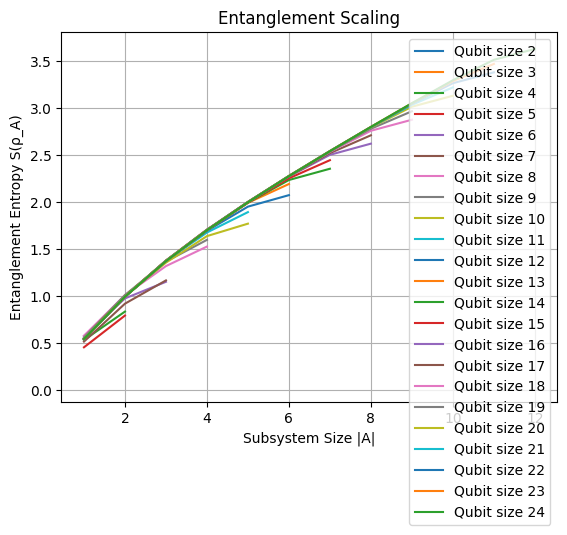

In [ ]:
# Only for this case since we know the final statevector we will
# just generate the statevector and avoid re-extracting it from
# the exponentially deep circuit
for i in range(2, 25):
    entropies: list[float] = []
    psi = generate_area_law_state(i)

    for k in range(1, i // 2 + 1):
        rho_A = partial_trace(psi, list(range(k, i)))  # Trace out rest
        S = entropy(rho_A, base=2)
        entropies.append(S)

    plt.plot(range(1, i // 2 + 1), entropies, label=f"Qubit size {i}")

plt.xlabel("Subsystem Size |A|")
plt.ylabel("Entanglement Entropy S(ρ_A)")
plt.title("Entanglement Scaling")
plt.grid(True)
plt.legend()
plt.show()

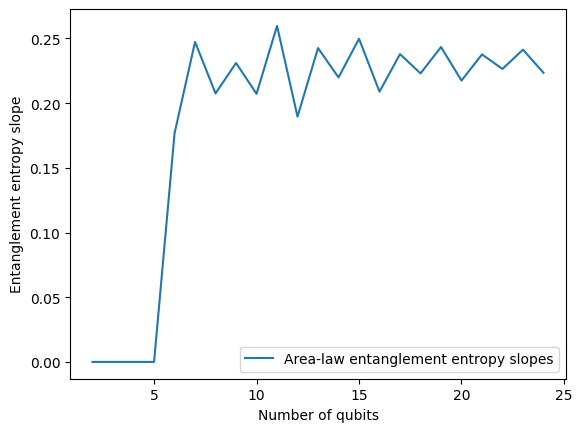

In [ ]:
area_law_entanglement_entropy_slopes: list[float] = []

# Only for this case since we know the final statevector we will
# just generate the statevector and avoid re-extracting it from
# the exponentially deep circuit
for i in range(2, 25):
    area_law_entanglement_entropy_slopes.append(
        calculate_entanglement_entropy_slope(generate_area_law_state(i))
    )

plt.plot(
    range(2, 25),
    area_law_entanglement_entropy_slopes,
    label="Area-law entanglement entropy slopes",
)
plt.xlabel("Number of qubits")
plt.ylabel("Entanglement entropy slope")
plt.legend()
plt.show()

We can see in the case of QCNN the max entropy doesn't change much, which shows its weak entanglement and makes it a great candidate for MPS compilation. Additionally, note the very small slope which further confirms its fit.

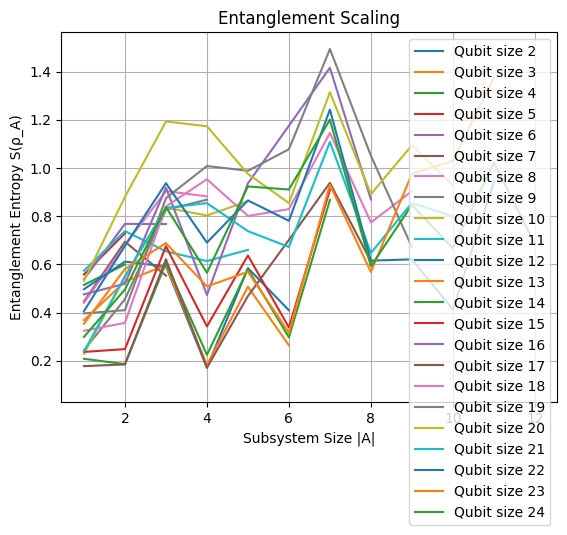

In [12]:
calculate_entanglement_entropy(generate_qcnn_circuit, range(2, 25))

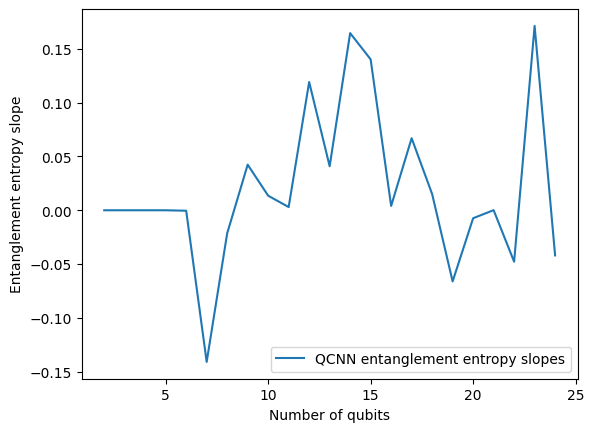

In [13]:
qcnn_entanglement_entropy_slopes = calculate_avg_entanglement_entropy_slope(
    generate_qcnn_circuit, range(2, 25)
)

plt.plot(
    range(2, 25),
    qcnn_entanglement_entropy_slopes,
    label="QCNN entanglement entropy slopes",
)
plt.xlabel("Number of qubits")
plt.ylabel("Entanglement entropy slope")
plt.legend()
plt.show()

GHZ states are not area-law or volume-law entangled. They exhibit non-local, global entanglement with constant bipartite entanglement entropy.

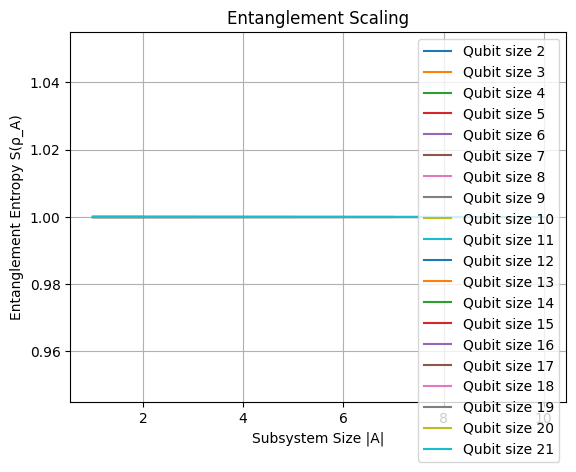

In [29]:
calculate_entanglement_entropy(generate_ghz_circuit, range(2, 22))

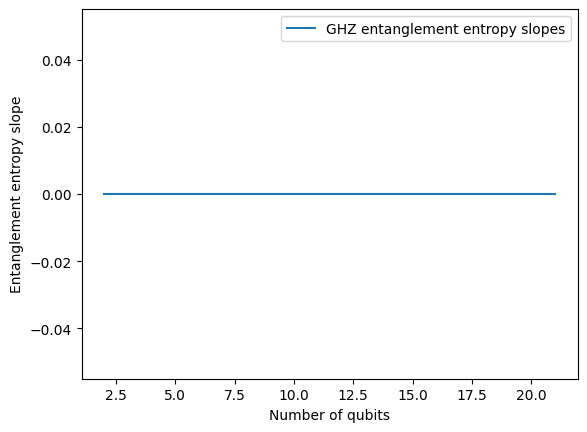

In [30]:
ghz_entanglement_entropy_slopes = calculate_avg_entanglement_entropy_slope(
    generate_ghz_circuit, range(2, 22)
)

plt.plot(
    range(2, 22),
    ghz_entanglement_entropy_slopes,
    label="GHZ entanglement entropy slopes",
)
plt.xlabel("Number of qubits")
plt.ylabel("Entanglement entropy slope")
plt.legend()
plt.show()

Trivial bvlike circuits are a great test for compilers to see if the compiler can tell there is no entanglement. Fortunately, MPS approaches are very entanglement aware and thus will be optimal for such cases.

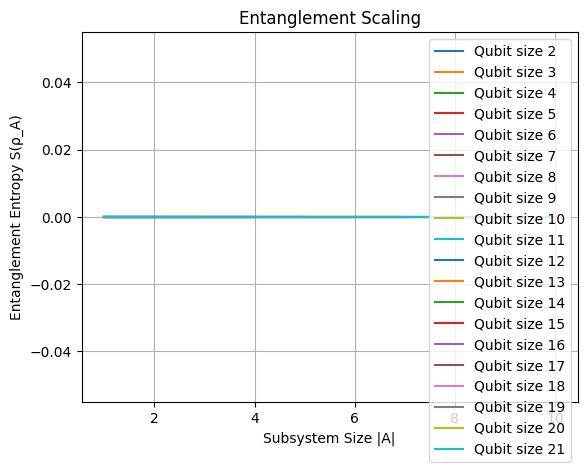

In [17]:
calculate_entanglement_entropy(generate_trivial_bvlike_circuit, range(2, 22))

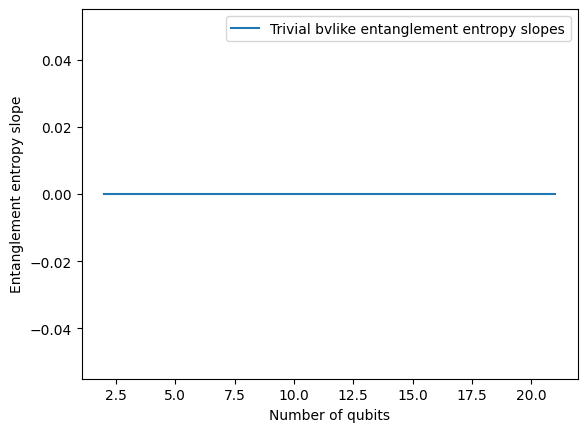

In [18]:
ghz_entanglement_entropy_slopes = calculate_avg_entanglement_entropy_slope(
    generate_trivial_bvlike_circuit, range(2, 22)
)

plt.plot(
    range(2, 22),
    ghz_entanglement_entropy_slopes,
    label="Trivial bvlike entanglement entropy slopes",
)
plt.xlabel("Number of qubits")
plt.ylabel("Entanglement entropy slope")
plt.legend()
plt.show()

Adjust the number of qubits to test according to the available RAM. The statevectors are often of type `np.complex128` which means they need 16 bytes to be represented. As we increase the number of qubits, the state size doubles, thus doubling the overall memory consumption. This is another reason why quantum computing is preferred given its exponentially compact memory representation.

You can use the following calculator to approximately infer how large of a state you can feasibly tackle on your RAM.

In [4]:
def calculate_required_ram(num_qubits: int) -> None:
    num_values = 2**num_qubits
    total_bytes = num_values * 16
    total_gb = total_bytes / 10**9
    print(
        f"Total memory requirement for storing the statevector in GiB: {total_gb}"
    )

We will try to update the benchmark to up to 30 qubits.

In [5]:
calculate_required_ram(29)

Total memory requirement for storing the statevector in GiB: 8.589934592


The following graphs illustrate the comparison between exact and aqc. The parameter generation used was:
```py
num_layers = int((2 + 1 * slope) * num_qubits)
num_sweeps = int((10 + 20 * slope) * num_qubits)
```
If desired fidelity is lower than needed, please increase the number of layers scaling (monitor for best parameter as it requires more time to generate layers and additionally more time for each sweep since there are more blocks to optimize).

In [10]:
qubit_range = list(range(2, 14))

### Area-law randomly generated circuits

Quantum state preparation circuits where the state is area-law entangled are a great use-case for MPS compilers. The circuits preparing these states scale exponentially with the number of qubits, whereas MPS approach scales linearly and if tailored properly, we can reach even lower depths without sacrificing fidelity.

For this benchmark we observed a significant reduction in depth and cx count while maintaining a fidelity of 0.87 at worst. The fidelity can be improved by increasing the number of layers and sweeps, but this will also increase the depth and cx count. However, since the depth scales exponentially, we can afford to use more layers without damaging the reduction considerably especially as we scale the number of qubits.

This benchmark is the most important one as it shows MPS compiler in its environment, where it is intended for. Such a benchmark is very valuable to compare with other compilers as state prep is used in many applications such as quantum machine learning, quantum chemistry, and more.

In [13]:
(
    ucc_base_cx_counts,
    ucc_base_depths,
    encoder_cx_counts,
    encoder_depths,
    encoder_fidelities,
) = benchmark(generate_area_law_circuit, qubit_range)

100%|██████████| 12/12 [05:31<00:00, 27.62s/it]

Benchmark circuits are area-law entangled. Avg slope of entanglement entropy: 0.242593424670838


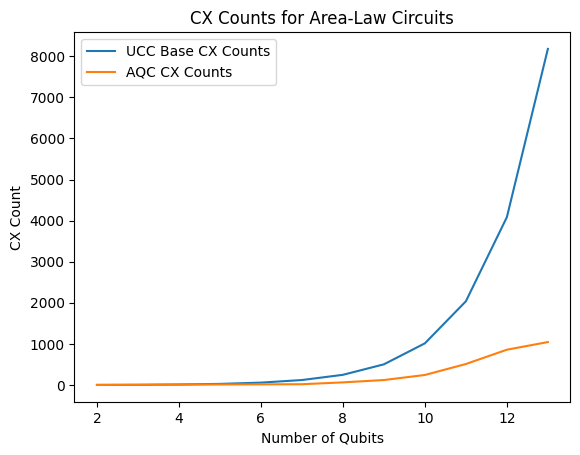

In [14]:
plt.plot(qubit_range, ucc_base_cx_counts, label="UCC Base CX Counts")
plt.plot(qubit_range, encoder_cx_counts, label="AQC CX Counts")
plt.xlabel("Number of Qubits")
plt.ylabel("CX Count")
plt.title("CX Counts for Area-Law Circuits")
plt.legend()
plt.show()

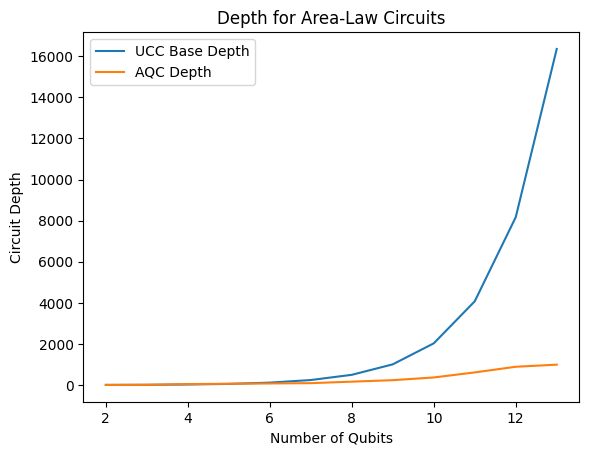

In [15]:
plt.plot(qubit_range, ucc_base_depths, label="UCC Base Depth")
plt.plot(qubit_range, encoder_depths, label="AQC Depth")
plt.xlabel("Number of Qubits")
plt.ylabel("Circuit Depth")
plt.title("Depth for Area-Law Circuits")
plt.legend()
plt.show()

/workspaces/ucc/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/workspaces/ucc/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


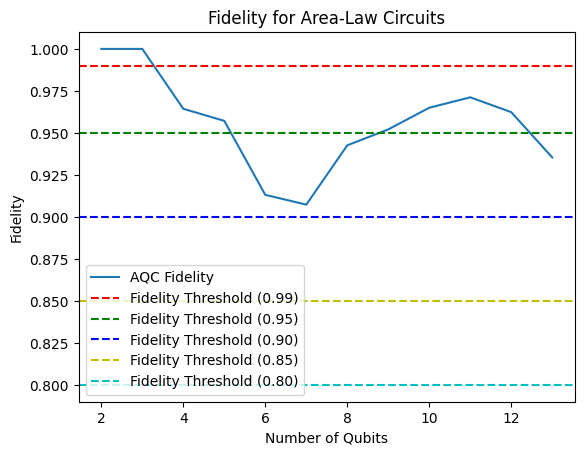

In [16]:
plt.plot(qubit_range, encoder_fidelities, label="AQC Fidelity")
plt.xlabel("Number of Qubits")
plt.ylabel("Fidelity")
plt.title("Fidelity for Area-Law Circuits")
plt.axhline(
    y=0.99, color="r", linestyle="--", label="Fidelity Threshold (0.99)"
)
plt.axhline(
    y=0.95, color="g", linestyle="--", label="Fidelity Threshold (0.95)"
)
plt.axhline(
    y=0.90, color="b", linestyle="--", label="Fidelity Threshold (0.90)"
)
plt.axhline(
    y=0.85, color="y", linestyle="--", label="Fidelity Threshold (0.85)"
)
plt.axhline(
    y=0.80, color="c", linestyle="--", label="Fidelity Threshold (0.80)"
)
plt.legend()
plt.show()

### QCNN Circuits

For QCNN we do not need as strong of a parameter as Area-law, so we will relax it to
```py
num_layers = 3
num_sweeps = 50 * num_qubits
```
QCNN circuits scale logarithmically, thus we can use a smaller number of layers and sweeps. In some instances the circuits are so trivial that even a single layer is enough to reach the desired fidelity, and may even be too much and increase circuit depth.

From the below benchmark, it's been observed that `QmprsCompiler` reduces total CX count slightly but increases circuit depth. This is expected given the linear scaling nature of MPS compiler and logarithmic scaling of QCNN. We test this for 25 qubits to see how it behaves with larger circuits. Should QCNN circuits be larger, we can still use fewer layers which naturally reduces fidelity but this is alright since QCNN circuits are used as ansatzes and will be variationally optimized anyway. The goal for MPS is to rather optimize the ansatz structure and reduce the CX count, which is what we observe in the benchmark.

Whilst not objectively better than QCNN, it provides means to reduce the CX count and can be further optimized via other compilation passes to optimize depth.

In [11]:
(
    ucc_base_cx_counts,
    ucc_base_depths,
    encoder_cx_counts,
    encoder_depths,
    encoder_fidelities,
) = benchmark(generate_qcnn_circuit, qubit_range)

100%|██████████| 12/12 [00:32<00:00,  2.75s/it]

Benchmark circuits are area-law entangled. Avg slope of entanglement entropy: 0.04089814370615322


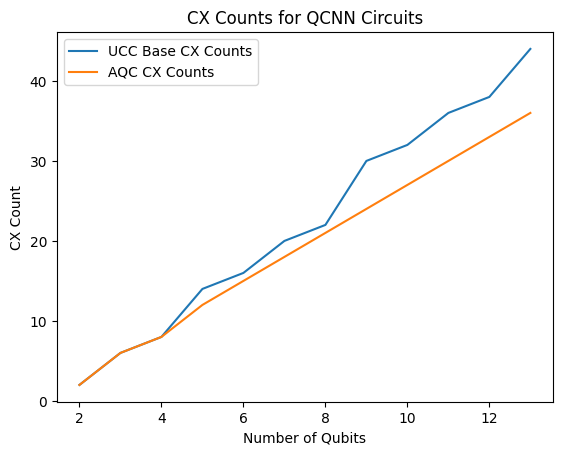

In [13]:
plt.plot(qubit_range, ucc_base_cx_counts, label="UCC Base CX Counts")
plt.plot(qubit_range, encoder_cx_counts, label="AQC CX Counts")
plt.xlabel("Number of Qubits")
plt.ylabel("CX Count")
plt.title("CX Counts for QCNN Circuits")
plt.legend()
plt.show()

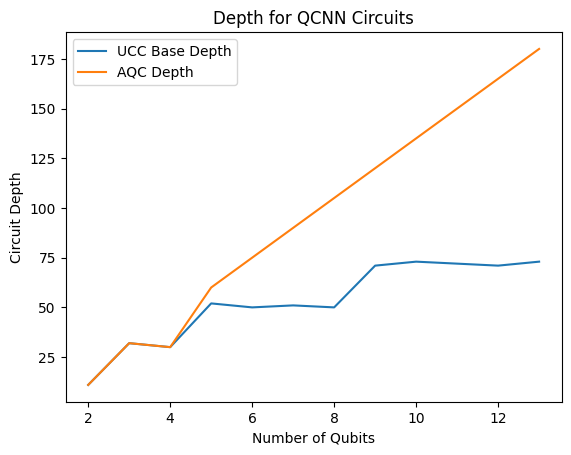

In [14]:
plt.plot(qubit_range, ucc_base_depths, label="UCC Base Depth")
plt.plot(qubit_range, encoder_depths, label="AQC Depth")
plt.xlabel("Number of Qubits")
plt.ylabel("Circuit Depth")
plt.title("Depth for QCNN Circuits")
plt.legend()
plt.show()

/workspaces/ucc/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/workspaces/ucc/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


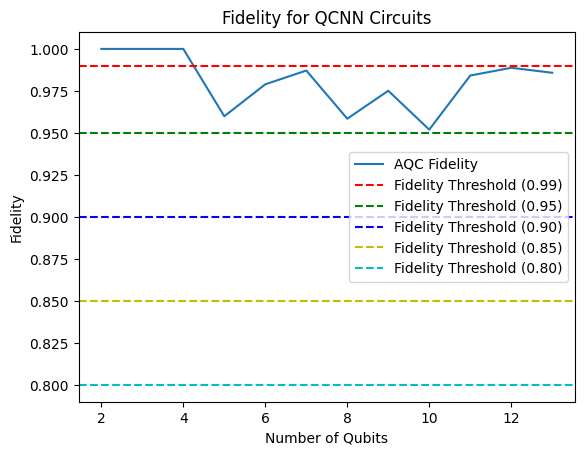

In [16]:
plt.plot(qubit_range, encoder_fidelities, label="AQC Fidelity")
plt.xlabel("Number of Qubits")
plt.ylabel("Fidelity")
plt.title("Fidelity for QCNN Circuits")
plt.axhline(
    y=0.99, color="r", linestyle="--", label="Fidelity Threshold (0.99)"
)
plt.axhline(
    y=0.95, color="g", linestyle="--", label="Fidelity Threshold (0.95)"
)
plt.axhline(
    y=0.90, color="b", linestyle="--", label="Fidelity Threshold (0.90)"
)
plt.axhline(
    y=0.85, color="y", linestyle="--", label="Fidelity Threshold (0.85)"
)
plt.axhline(
    y=0.80, color="c", linestyle="--", label="Fidelity Threshold (0.80)"
)
plt.legend()
plt.show()

### GHZ Circuits

GHZ circuits are simple but useful circuits that prepare GHZ states. They are a cornerstone of MPS compilers given their unique properties.

Works by Smith et al. have shown that MPS compilers can reduce the depth of GHZ circuits to constant depth via mid-circuit measurement. We can see why mid-circuit measurement is valuable as even a single layer is too much for encoding the GHZ state. This makes `QmprsCompiler` a poor fit for such a state especially when we can construct GHZ using binary tree structures.
```py
num_layers = 1
num_sweeps = 15 * num_qubits
```

In [17]:
(
    ucc_base_cx_counts,
    ucc_base_depths,
    encoder_cx_counts,
    encoder_depths,
    encoder_fidelities,
) = benchmark(generate_ghz_circuit, qubit_range)

100%|██████████| 12/12 [00:26<00:00,  2.24s/it]

Benchmark circuits are area-law entangled. Avg slope of entanglement entropy: 0.0


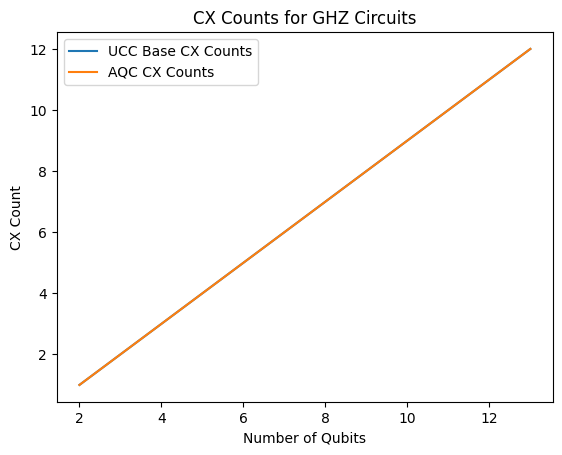

In [19]:
plt.plot(qubit_range, ucc_base_cx_counts, label="UCC Base CX Counts")
plt.plot(qubit_range, encoder_cx_counts, label="AQC CX Counts")
plt.xlabel("Number of Qubits")
plt.ylabel("CX Count")
plt.title("CX Counts for GHZ Circuits")
plt.legend()
plt.show()

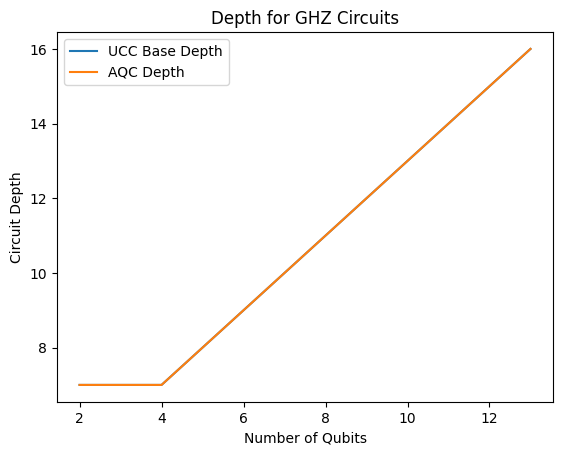

In [20]:
plt.plot(qubit_range, ucc_base_depths, label="UCC Base Depth")
plt.plot(qubit_range, encoder_depths, label="AQC Depth")
plt.xlabel("Number of Qubits")
plt.ylabel("Circuit Depth")
plt.title("Depth for GHZ Circuits")
plt.legend()
plt.show()

/workspaces/ucc/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/workspaces/ucc/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


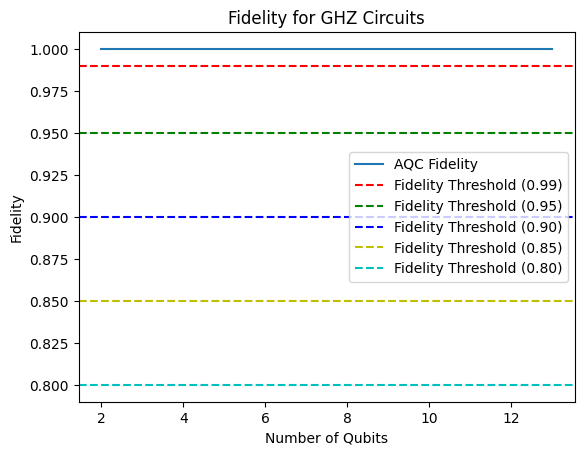

In [21]:
plt.plot(qubit_range, encoder_fidelities, label="AQC Fidelity")
plt.xlabel("Number of Qubits")
plt.ylabel("Fidelity")
plt.title("Fidelity for GHZ Circuits")
plt.axhline(
    y=0.99, color="r", linestyle="--", label="Fidelity Threshold (0.99)"
)
plt.axhline(
    y=0.95, color="g", linestyle="--", label="Fidelity Threshold (0.95)"
)
plt.axhline(
    y=0.90, color="b", linestyle="--", label="Fidelity Threshold (0.90)"
)
plt.axhline(
    y=0.85, color="y", linestyle="--", label="Fidelity Threshold (0.85)"
)
plt.axhline(
    y=0.80, color="c", linestyle="--", label="Fidelity Threshold (0.80)"
)
plt.legend()
plt.show()

### Trivial bvlike Circuits

This benchmark is simply to show that MPS compilers are entanglement aware and can detect when there is no entanglement. As such, we will show that a single layer is enough to reach 1.0 fidelity and the circuit depth is 1 with 0 CX count.
```py
num_layers = 1
num_sweeps = 15 * num_qubits
```

In [22]:
(
    ucc_base_cx_counts,
    ucc_base_depths,
    encoder_cx_counts,
    encoder_depths,
    encoder_fidelities,
) = benchmark(generate_trivial_bvlike_circuit, qubit_range)

100%|██████████| 12/12 [00:30<00:00,  2.57s/it]

Benchmark circuits are area-law entangled. Avg slope of entanglement entropy: 0.0


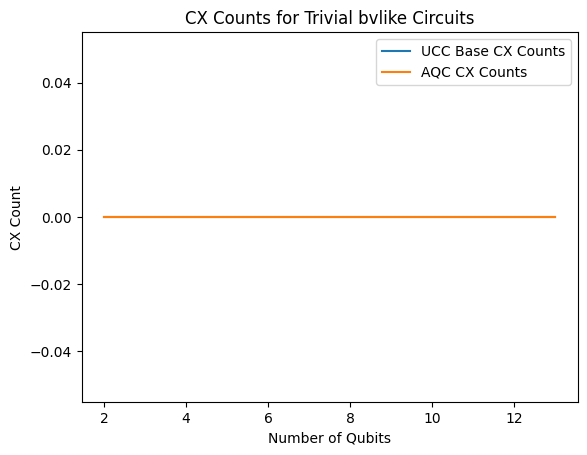

In [23]:
plt.plot(qubit_range, ucc_base_cx_counts, label="UCC Base CX Counts")
plt.plot(qubit_range, encoder_cx_counts, label="AQC CX Counts")
plt.xlabel("Number of Qubits")
plt.ylabel("CX Count")
plt.title("CX Counts for Trivial bvlike Circuits")
plt.legend()
plt.show()

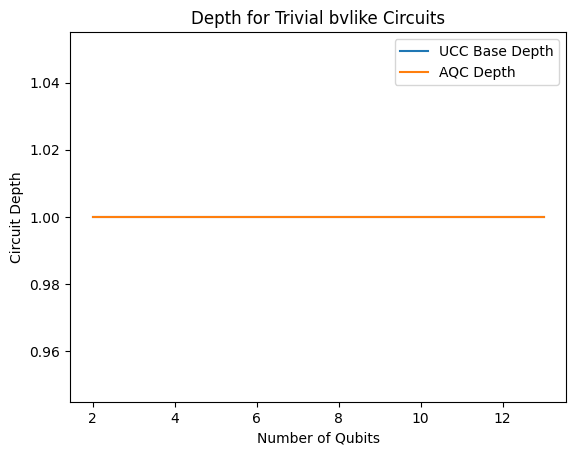

In [24]:
plt.plot(qubit_range, ucc_base_depths, label="UCC Base Depth")
plt.plot(qubit_range, encoder_depths, label="AQC Depth")
plt.xlabel("Number of Qubits")
plt.ylabel("Circuit Depth")
plt.title("Depth for Trivial bvlike Circuits")
plt.legend()
plt.show()

/workspaces/ucc/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/workspaces/ucc/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


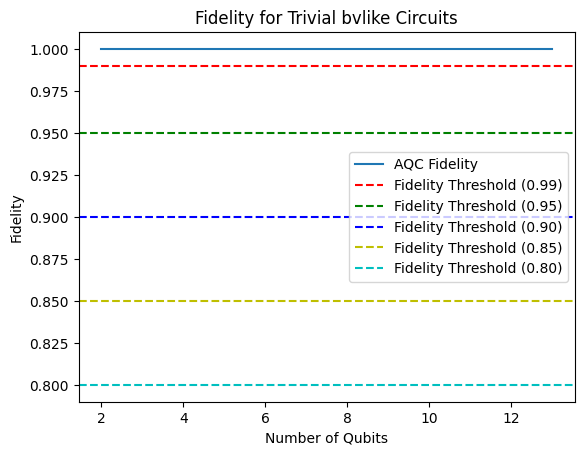

In [25]:
plt.plot(qubit_range, encoder_fidelities, label="AQC Fidelity")
plt.xlabel("Number of Qubits")
plt.ylabel("Fidelity")
plt.title("Fidelity for Trivial bvlike Circuits")
plt.axhline(
    y=0.99, color="r", linestyle="--", label="Fidelity Threshold (0.99)"
)
plt.axhline(
    y=0.95, color="g", linestyle="--", label="Fidelity Threshold (0.95)"
)
plt.axhline(
    y=0.90, color="b", linestyle="--", label="Fidelity Threshold (0.90)"
)
plt.axhline(
    y=0.85, color="y", linestyle="--", label="Fidelity Threshold (0.85)"
)
plt.axhline(
    y=0.80, color="c", linestyle="--", label="Fidelity Threshold (0.80)"
)
plt.legend()
plt.show()

### Area-law notes

From extensive training given the aforementioned hardware, we find `QmprsCompiler` to plateau around 0.87 fidelity with the current automated parameters as the number of qubits increases. If more fidelity is required, one should opt for a steeper number of layers and number of sweeps growth in `QmprsCompiler.optimal_params()`.

The main intended use-case of `QmprsCompiler` at the time of writing this benchmark is for area-law entangled circuits and further work in the near-term will focus on improving the runtime and fidelity of the compilation.

We can see the depth scaling is exponentially reduced, which yields significantly better results as the system size scales. One again can increase the depth scaling to tradeoff with better fidelity depending on pure compilation or use for preparing initial states for quantum algorithms.

### Volume-law circuit generator

We use the random Clifford circuit to generate volume-law entangled circuits. MPS/TN approaches are generally not performant enough for volume-law states as they require exponential bond dimension to be represented. This becomes an issue as we truncate the bond dimension to 2 for MPS encoding and to reach target fidelity we would need significantly more layers.

Randomly generated circuits are considered pathological highly-entangled circuits depending on their gateset, and are very hard to simulate and approximate which is why we use quantum computers to do so. Given their random nature, they can technically have instances which are area-law entangled or even trivial, but in general they are volume-law entangled.

`QmprsCompiler` provides a smooth transition to use more layers depending on the entanglement entropy slope (where volume-law states are usually 1.0) and this can be modified to fine-tune how many more layers to allocate for such states.

As any algorithm, `qmprs` is *currently* not consistently performant enough for large-scale volume-law entangled compilation. We however provide as much support to improve its fidelity whilst being mindful of runtime and memory.

In [11]:
def generate_random_clifford_circuit(
    num_qubits: int, seed: int = 12345
) -> QuantumCircuit:
    from qiskit.circuit.random import random_clifford_circuit

    gates = ["cx", "cz", "cy", "swap", "x", "y", "z", "s", "sdg", "h"]
    circuit = random_clifford_circuit(
        num_qubits,
        gates=gates,
        num_gates=10 * num_qubits * num_qubits,
        seed=seed,
    )

    return circuit

Random-Clifford circuits possess volume-law entanglement on avg, which is when the slope peaks at 1. Given its random nature, it sometimes can go as low as area-law, but mostly will be between 0.7 and above as we scale the number of qubits. This shows why they are hard to approximate at times, and at other times we capture them perfectly.

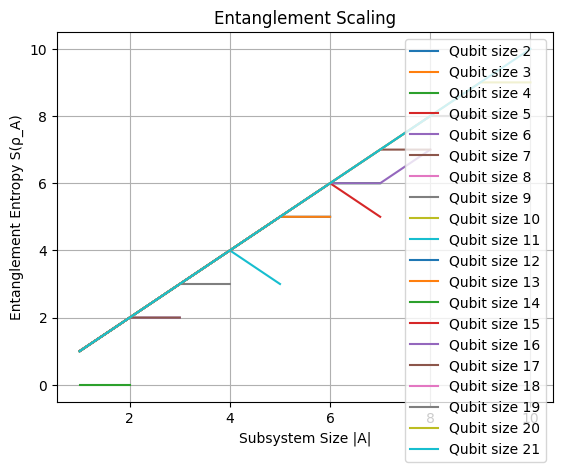

In [10]:
calculate_entanglement_entropy(generate_random_clifford_circuit, range(2, 22))

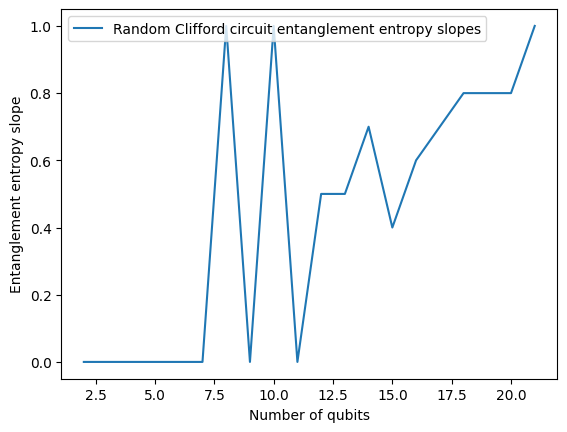

In [11]:
random_clifford_entanglement_entropy_slopes = (
    calculate_avg_entanglement_entropy_slope(
        generate_random_clifford_circuit, range(2, 22)
    )
)

plt.plot(
    range(2, 22),
    random_clifford_entanglement_entropy_slopes,
    label="Random Clifford circuit entanglement entropy slopes",
)
plt.xlabel("Number of qubits")
plt.ylabel("Entanglement entropy slope")
plt.legend()
plt.show()

We have to use a more rigrous parameter for volume-law circuits.
```py
num_layers = int((2 + 1 * slope) * num_qubits)
num_sweeps = int((10 + 20 * slope) * num_qubits)
```

In [12]:
(
    ucc_base_cx_counts,
    ucc_base_depths,
    encoder_cx_counts,
    encoder_depths,
    encoder_fidelities,
) = benchmark(generate_random_clifford_circuit, qubit_range)

 50%|█████     | 6/12 [00:02<00:03,  1.60it/s]/workspaces/ucc/.venv/lib/python3.12/site-packages/ucc/aqc/qmprs_compiler.py:68: UserWarning: Warning: The state is volume-law entangled. Compression may be too lossy.
  warnings.warn(
 67%|██████▋   | 8/12 [00:22<00:21,  5.26s/it]/workspaces/ucc/.venv/lib/python3.12/site-packages/ucc/aqc/qmprs_compiler.py:68: UserWarning: Warning: The state is volume-law entangled. Compression may be too lossy.
  warnings.warn(
100%|██████████| 12/12 [04:43<00:00, 23.63s/it]

Benchmark circuits are area-law entangled. Avg slope of entanglement entropy: 0.4999999999999867


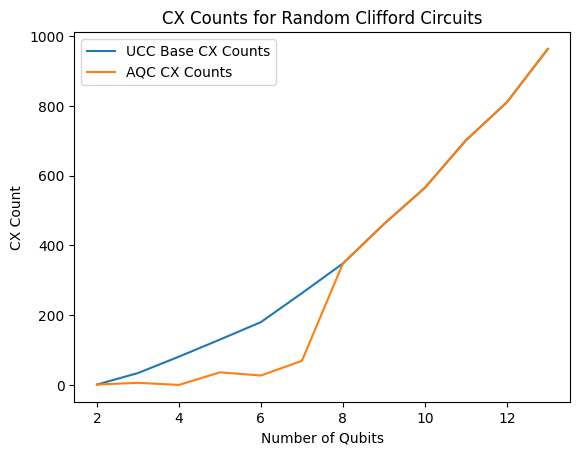

In [13]:
plt.plot(qubit_range, ucc_base_cx_counts, label="UCC Base CX Counts")
plt.plot(qubit_range, encoder_cx_counts, label="AQC CX Counts")
plt.xlabel("Number of Qubits")
plt.ylabel("CX Count")
plt.title("CX Counts for Random Clifford Circuits")
plt.legend()
plt.show()

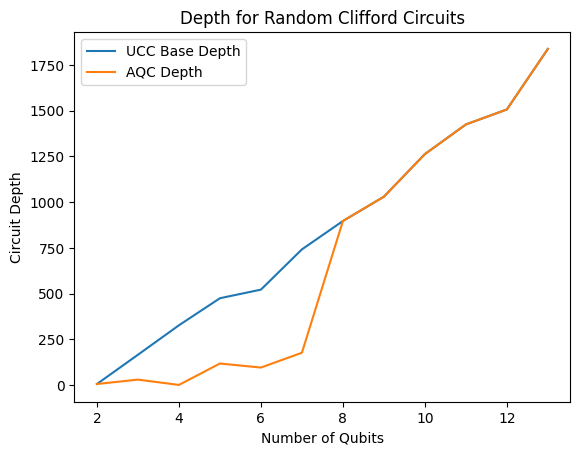

In [14]:
plt.plot(qubit_range, ucc_base_depths, label="UCC Base Depth")
plt.plot(qubit_range, encoder_depths, label="AQC Depth")
plt.xlabel("Number of Qubits")
plt.ylabel("Circuit Depth")
plt.title("Depth for Random Clifford Circuits")
plt.legend()
plt.show()

/workspaces/ucc/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/workspaces/ucc/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


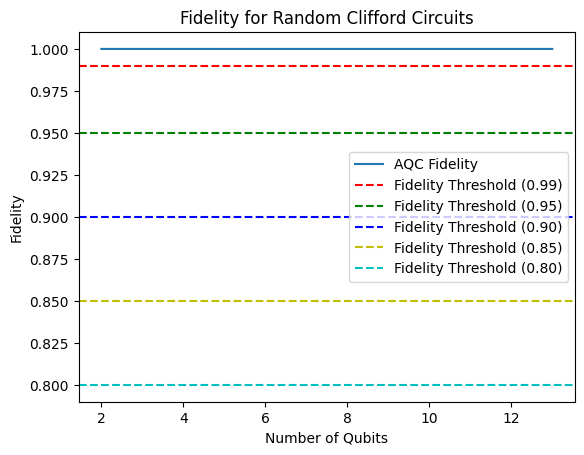

In [15]:
plt.plot(qubit_range, encoder_fidelities, label="AQC Fidelity")
plt.xlabel("Number of Qubits")
plt.ylabel("Fidelity")
plt.title("Fidelity for Random Clifford Circuits")
plt.axhline(
    y=0.99, color="r", linestyle="--", label="Fidelity Threshold (0.99)"
)
plt.axhline(
    y=0.95, color="g", linestyle="--", label="Fidelity Threshold (0.95)"
)
plt.axhline(
    y=0.90, color="b", linestyle="--", label="Fidelity Threshold (0.90)"
)
plt.axhline(
    y=0.85, color="y", linestyle="--", label="Fidelity Threshold (0.85)"
)
plt.axhline(
    y=0.80, color="c", linestyle="--", label="Fidelity Threshold (0.80)"
)
plt.legend()
plt.show()

### Conclusion

`QmprsCompiler` is meant to be the state-of-the-art MPS compiler to provide O(N) for area-law entangled states. It is not meant to be used for volume-law entangled circuits, but it can still provide some value in such cases depending on the circuit structure.

Given the above benchmarks, we recommend `QmprsCompiler` to be used as a complement to `ucc.compile` for area-law entangled circuits and when the fidelity is high enough. This will keep the worst-case performance as is as we discard `QmprsCompiler` compilation for such instances, and it provides considerable improvement for cases where it is applicable.

`QmprsCompiler` still is in early stages and through this benchmark many potentials and limitations have been identified. We will continue to improve it and provide more benchmarks as we progress. Details on future steps will be incrementally provided in `qmprs` repository. Main focus will be on improving fidelity and reducing runtime and memory consumption.